# Scaling Python with Azure ML and Dask

![Describe gif](media/describe3.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [1]:
pip install --upgrade azureml-sdk[notebooks] azureml-dataprep[fuse] fastparquet pyarrow dask distributed lz4

In [2]:
pip uninstall azureml-samples -y # stupid 

In [3]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

In [4]:
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [5]:
import os
import sys
import dask
import glob
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML Setup

Get the workspace.

In [6]:
ws = Workspace.from_config()
ws

Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

### Create environment 

Create the environment to be used on the remote cluster. 

In [7]:
env_name = 'dask-env'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask-env', '1')

### Create dataset

Create the dataset to be used. 

In [9]:
dataset_name = 'weather-files'
data_paths   = ['https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/**']

if dataset_name not in ws.datasets:
    ds = Dataset.File.from_files(data_paths, validate=False)
    ds = ds.register(ws, dataset_name)
else:
    ds = ws.datasets[dataset_name]
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "132f84ee-4f89-45f7-b2ca-fe22fe332295",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [10]:
pool_name = 'dask-pool'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=dask-pool, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/bigdata/computes/dask-pool, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Dataset overview

This uses an [Azure Open Dataset](https://azure.microsoft.com/services/open-datasets/catalog/) of [NOAA Integrated Surface Data (ISD)](https://azure.microsoft.com/services/open-datasets/catalog/noaa-integrated-surface-data/) containing worldwide hourly weather data such as temperature, precipitation, and wind. 

Expanded in memory, the full dataset is ~660 GB. It is stored in compressed parquet files in a blob container partitioned by year and month. The dataset is updated daily. Compressed, the files for the dataset are ~8 GB. Uncompressed, the files for the dataset are ~150-200 GB.  

Specific years and months can be specified by `year=*/month=*/part-*.snappy.parquet`. 

The data begins in 2008 and contains 1 file per month. Each file can contain ~5 GB of data when in a dataframe in memory.

## Download dataset

In [11]:
data_path = '/mnt/noaa'

In [12]:
os.system('sudo chmod 777 /mnt'); # stupid 

In [13]:
%time ds.download(data_path)

In [14]:
files = glob.glob(f'{data_path}/year=*/month=*/*.parquet', recursive=True)
len(files)

144

## Pandas

In [15]:
files = glob.glob(f'{data_path}/year=2019/month=12/*.parquet', recursive=True) # 1 month of data
files

['/mnt/noaa/year=2019/month=12/part-00024-tid-1187733214417029249-81f56df1-4ad1-4c02-8e3e-e4416c14ebed-59417-1.c000.snappy.parquet']

In [16]:
df = pd.read_parquet(files[0])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,724750,23176,2019-12-01 00:00:00,38.417,-113.017,1536.0,220.0,4.6,-5.0,1025.4,...,NaN,NaN,NaN,NaN,MILFORD MUNICIPAL AIRPORT,US,724750-23176,2019,1,1.0
1,724750,23176,2019-12-01 00:52:00,38.427,-113.012,1536.0,180.0,2.1,-7.8,1026.7,...,NaN,NaN,NaN,NaN,MILFORD MUNICIPAL AIRPORT,US,724750-23176,2019,1,1.0
2,724750,23176,2019-12-01 01:52:00,38.427,-113.012,1536.0,200.0,2.1,-7.8,1026.6,...,NaN,NaN,NaN,NaN,MILFORD MUNICIPAL AIRPORT,US,724750-23176,2019,1,1.0
3,724750,23176,2019-12-01 02:52:00,38.427,-113.012,1536.0,190.0,2.6,-9.4,1027.7,...,NaN,NaN,NaN,NaN,MILFORD MUNICIPAL AIRPORT,US,724750-23176,2019,1,1.0
4,724750,23176,2019-12-01 03:00:00,38.417,-113.017,1536.0,190.0,2.6,-9.4,1027.7,...,NaN,NaN,NaN,NaN,MILFORD MUNICIPAL AIRPORT,US,724750-23176,2019,1,1.0


In [17]:
%time len(df)

CPU times: user 20 µs, sys: 6 µs, total: 26 µs
Wall time: 33.9 µs


9958987

In [18]:
%time df.describe()

CPU times: user 5.41 s, sys: 1.36 s, total: 6.77 s
Wall time: 6.77 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,9.958987e+06,9.958987e+06,9.958987e+06,9.311875e+06,9.555530e+06,9.729375e+06,4.569269e+06,1.511730e+06,517532.000000,2.684580e+06,2.684580e+06,144621.000000,9958987.0,9.958987e+06,9958987.0
mean,3.563873e+01,-2.724598e+01,3.590225e+02,1.671123e+02,3.550951e+00,5.736652e+00,1.014028e+03,3.745591e+01,3.790962,1.502598e+01,2.257580e+03,10.991419,2019.0,1.595962e+01,1.0
std,2.454838e+01,7.889429e+01,7.000842e+02,1.137683e+02,3.079003e+00,1.260263e+01,1.174117e+01,3.010136e+01,3.035803,2.900211e+01,4.172159e+03,18.797680,0.0,8.932644e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.400000e+01,8.614000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2019.0,1.000000e+00,1.0
25%,3.236400e+01,-9.198100e+01,3.300000e+01,6.000000e+01,1.500000e+00,-1.200000e+00,1.008400e+03,1.000000e+01,1.000000,1.000000e+00,0.000000e+00,1.000000,2019.0,8.000000e+00,1.0
50%,4.153300e+01,-5.396700e+01,1.600000e+02,1.700000e+02,3.000000e+00,5.000000e+00,1.014900e+03,4.400000e+01,4.000000,1.000000e+00,0.000000e+00,1.000000,2019.0,1.600000e+01,1.0
75%,4.894100e+01,2.059300e+01,3.970000e+02,2.600000e+02,5.000000e+00,1.300000e+01,1.021600e+03,6.500000e+01,7.000000,1.200000e+01,6.000000e+01,15.000000,2019.0,2.400000e+01,1.0
max,8.365000e+01,1.797500e+02,9.999000e+03,3.600000e+02,8.800000e+01,6.000000e+01,1.088500e+03,9.900000e+01,9.000000,9.900000e+01,9.999000e+03,390.000000,2019.0,3.100000e+01,1.0


In [19]:
%time bites = df.memory_usage(index=True, deep=True).sum()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 3.97 s, sys: 60.2 ms, total: 4.03 s
Wall time: 4.02 s
Dataframe is: 4.79GB


In [20]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean()
means.head()

CPU times: user 673 ms, sys: 404 ms, total: 1.08 s
Wall time: 1.08 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-12-01,35.704098,-28.676539,360.953552,175.334623,3.984172,5.857012,1013.546711,46.324600,4.049514,14.998314,2112.794323,9.358607,2019,1,1.0
2019-12-02,35.524892,-26.631679,355.061030,193.481755,3.729187,5.131950,1013.759784,41.708790,4.231676,15.830040,2344.422002,10.376693,2019,2,1.0
2019-12-03,35.485208,-26.305099,356.886431,183.229631,3.412932,5.284834,1013.719291,36.476575,3.939467,16.796437,2508.400531,10.457428,2019,3,1.0
2019-12-04,35.682193,-26.356791,359.951759,179.814224,3.344442,5.905213,1012.489592,35.312662,3.690052,16.906751,2564.446335,8.732609,2019,4,1.0
2019-12-05,35.765339,-26.843494,365.376117,170.223265,3.381195,5.905333,1013.816402,34.095361,3.421218,15.723318,2459.378260,9.979785,2019,5,1.0


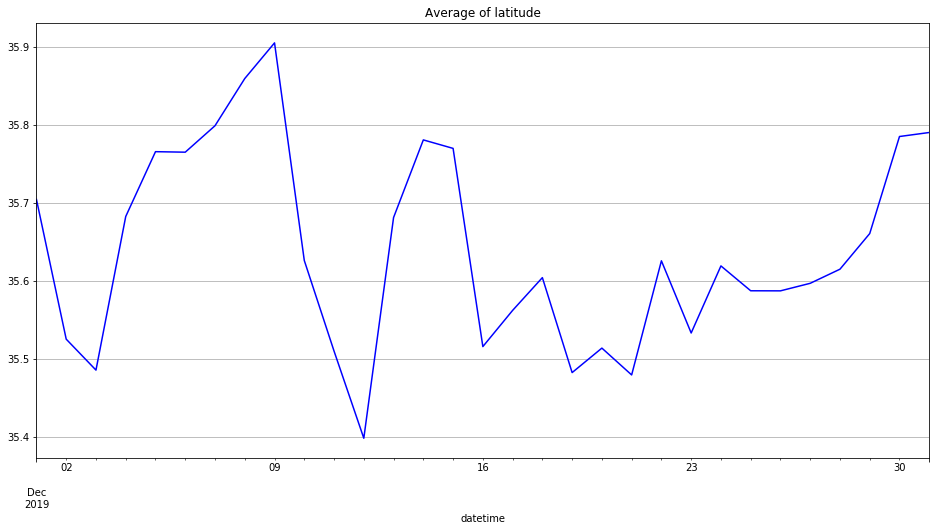

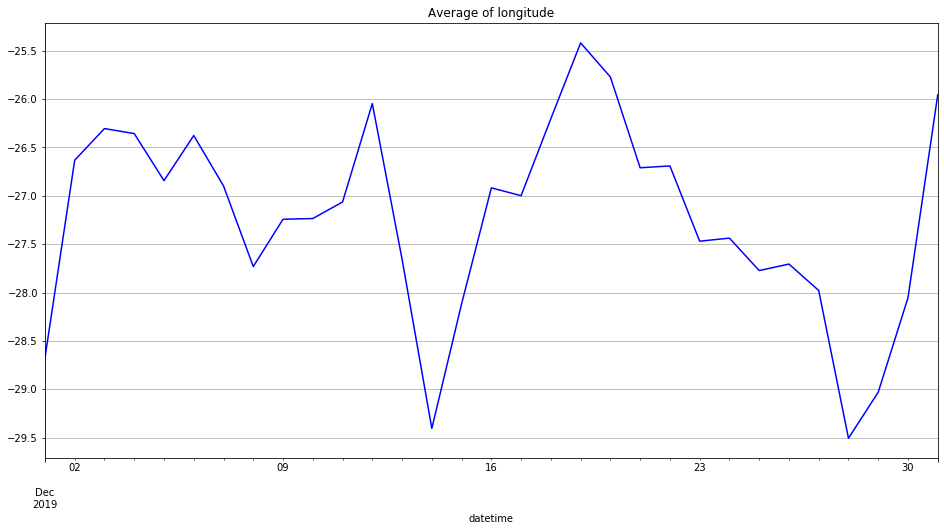

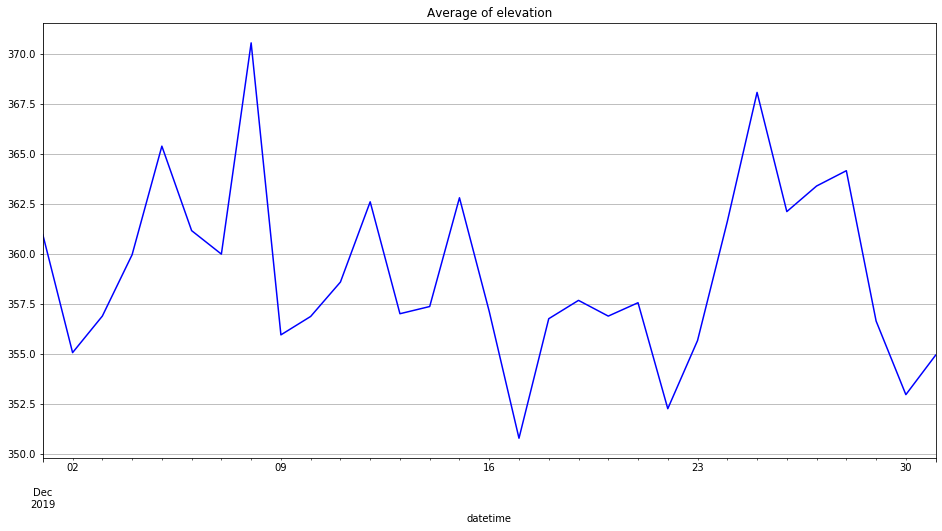

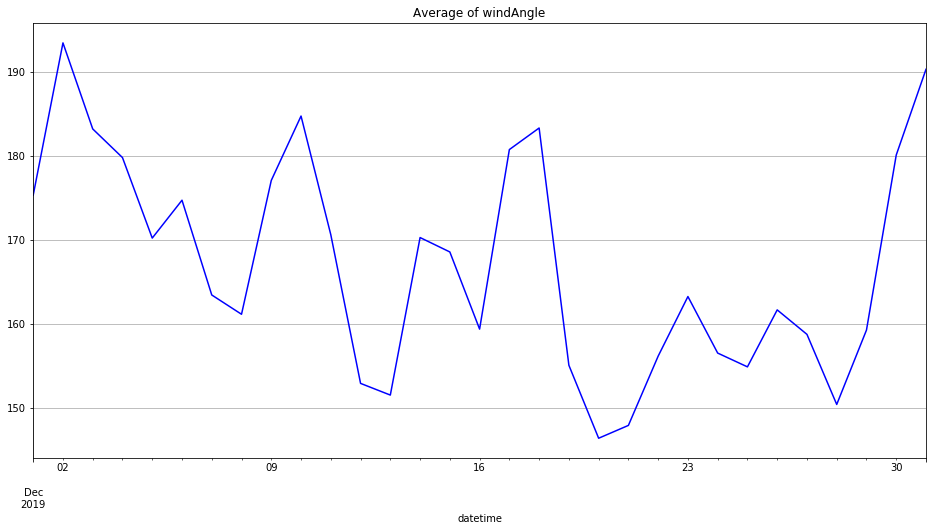

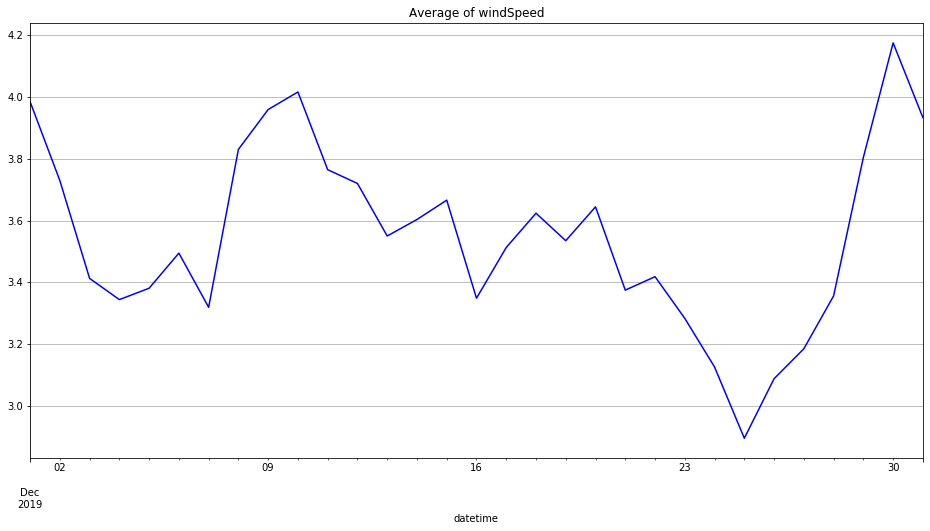

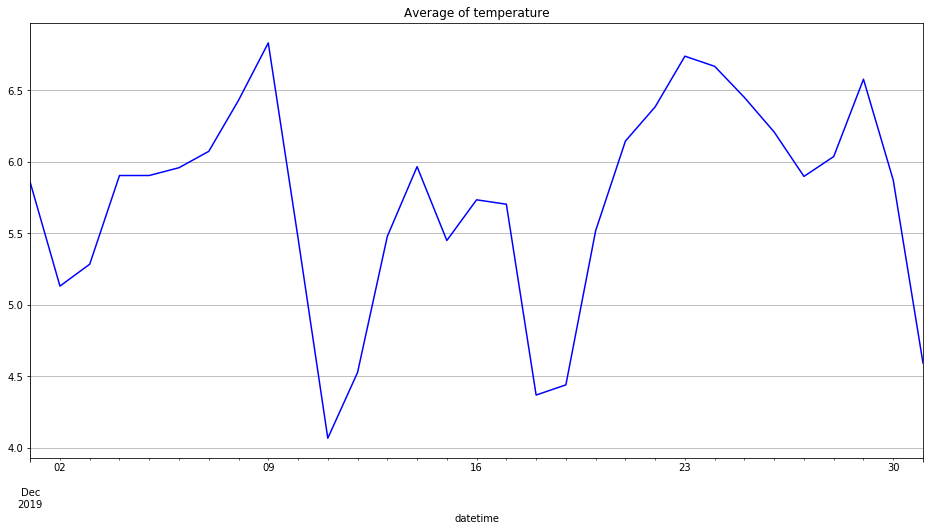

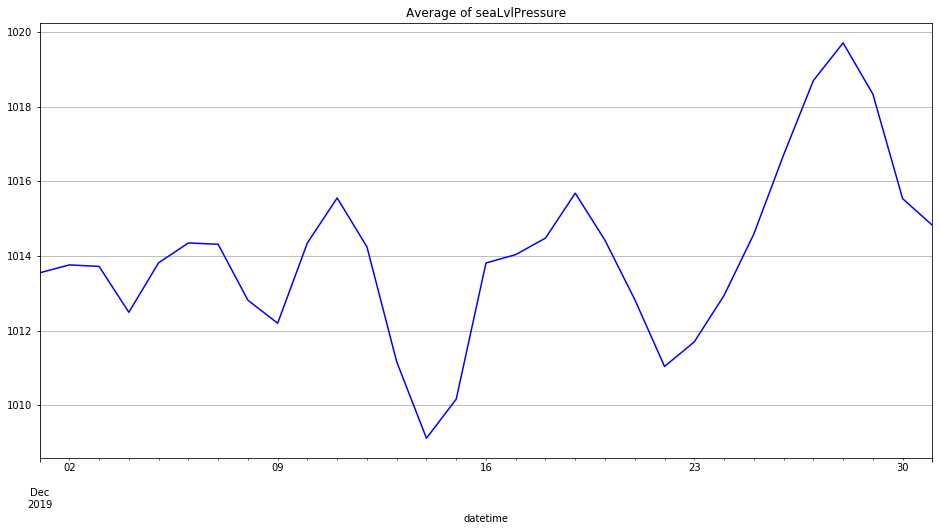

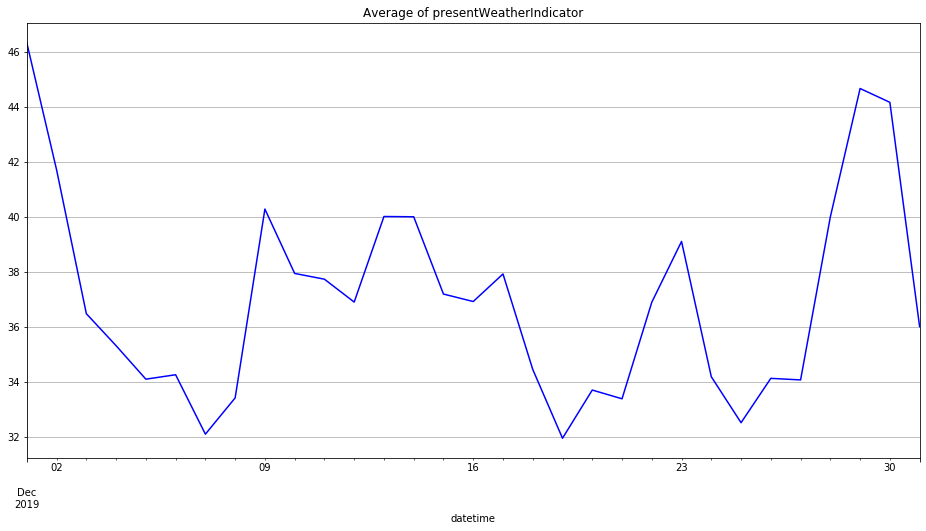

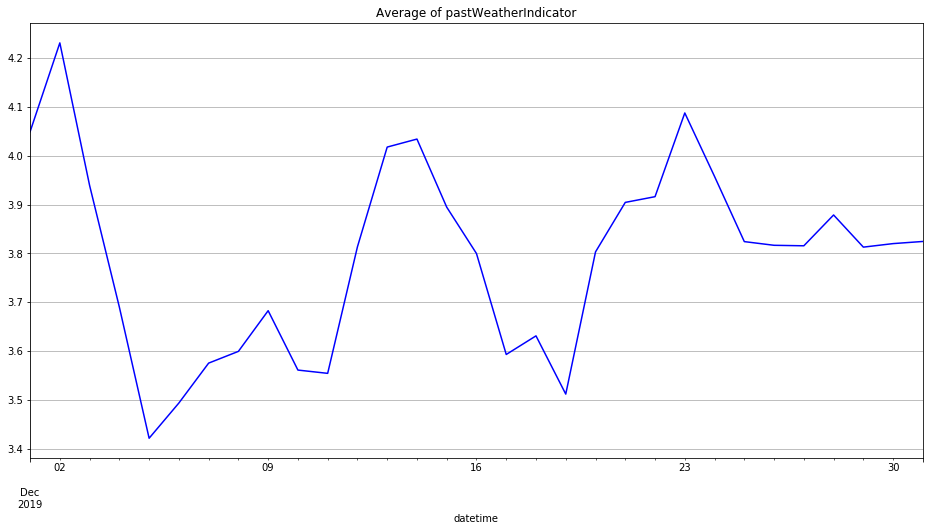

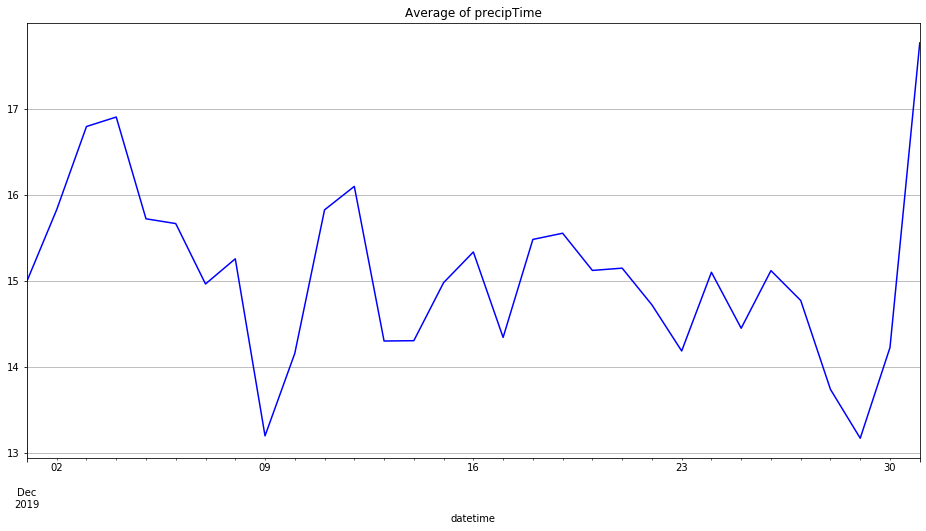

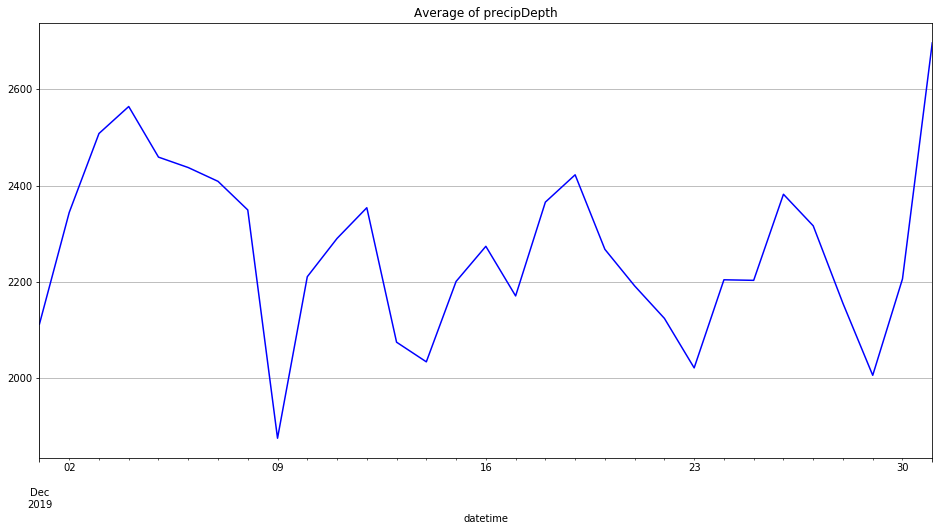

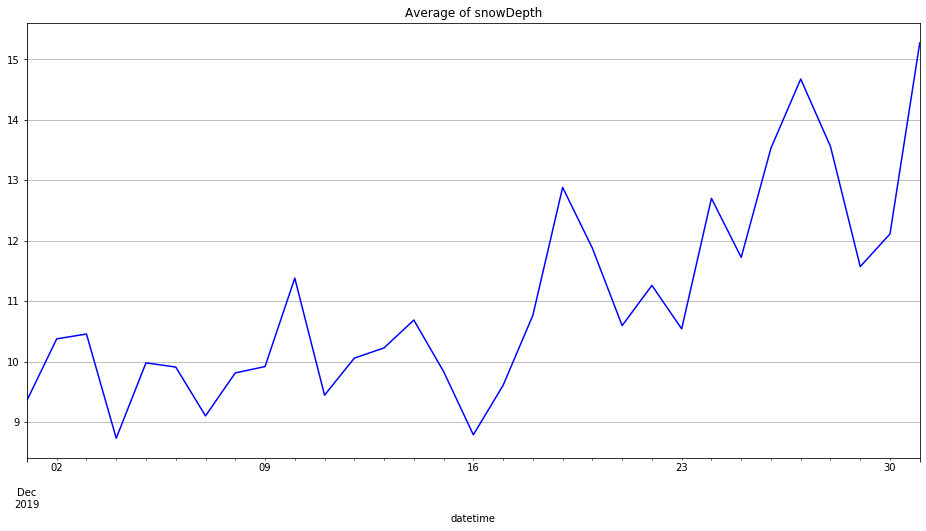

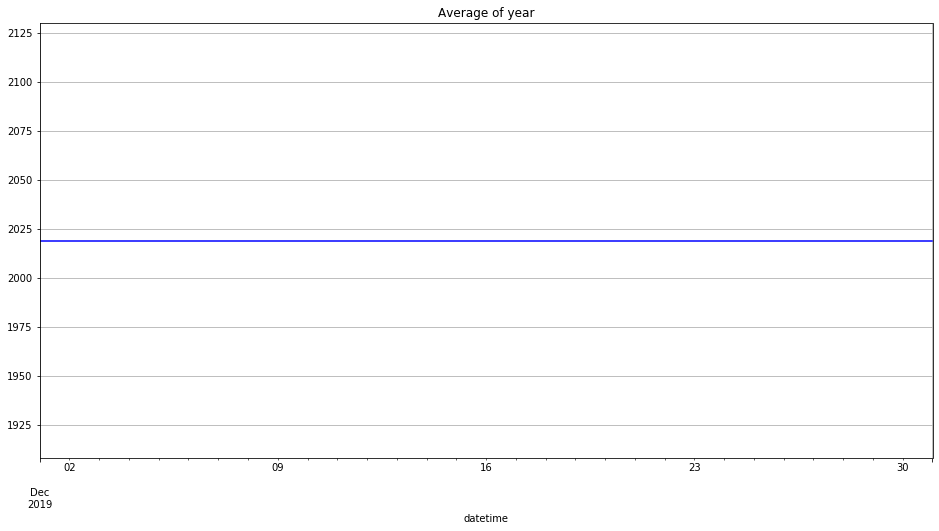

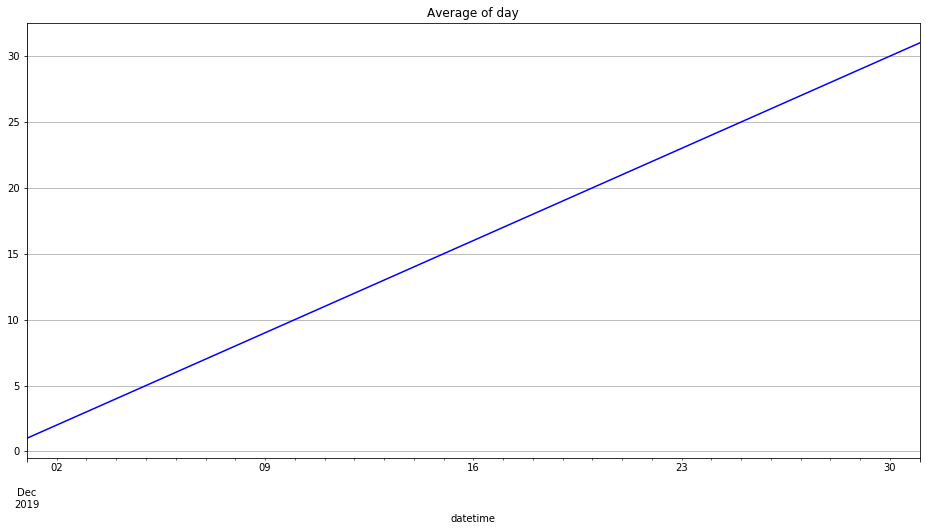

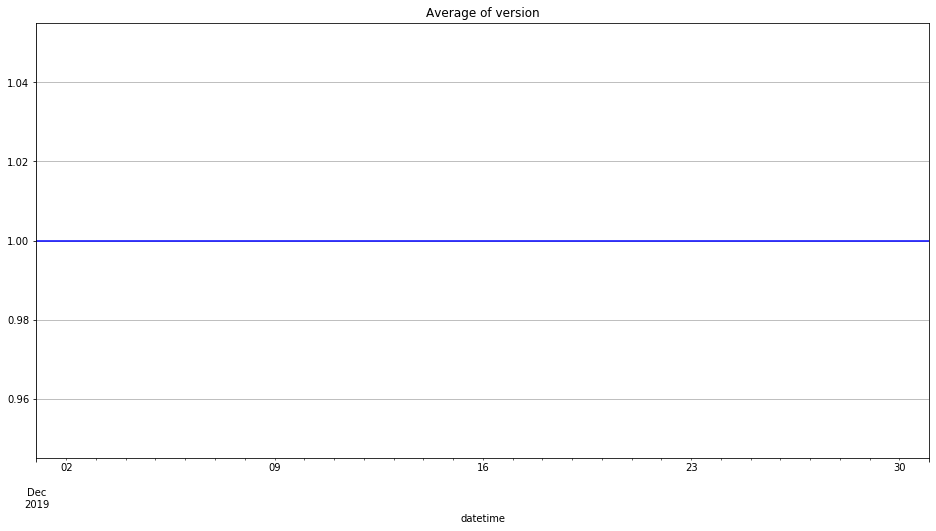

In [21]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 12, 1), datetime(2019, 12, 31)])
    plt.grid()

## Scaling with Dask

The first step in scaling up with Dask is to simply get a bigger VM. For non-GPU Compute Instances, the max is the `STANDARD_DS15_V2` with 20 cores and 140 GB of RAM. This is suitable for interactive querying and data preparation on about 1 year of the weather data, but not on the full dataset.

In [22]:
dashboard_port = 4242

c = Client(dashboard_address=f':{dashboard_port}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker




<Client: 'tcp://127.0.0.1:33379' processes=6 threads=24, memory=236.64 GB>


### Take some data

Take some data. The below cells may fail on smaller VMs. 1 year works semi-reliably on a `STANDARD_DS15_V2`, although computing the means fails sometimes.

You can use the dashboard to understand what is going on with this VM being used as a "local" cluster. 

In [23]:
start = 2017
end   = 2018

In [30]:
df = dask.delayed(dd.read_parquet)([f'{data_path}/year={year}/month=*/*.parquet' for year in range(start, end+1)], engine='pyarrow').compute().persist()
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,717250,99999,2017-01-01 00:00:00,48.050,-77.767,337.0,80.0,3.6,-14.2,1004.4,...,NaN,24.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
1,717250,99999,2017-01-01 00:00:00,48.053,-77.783,337.0,80.0,3.6,-14.0,1004.3,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
2,717250,99999,2017-01-01 01:00:00,48.053,-77.783,337.0,80.0,3.1,-14.0,1004.0,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
3,717250,99999,2017-01-01 02:00:00,48.053,-77.783,337.0,80.0,2.6,-14.0,1003.5,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
4,717250,99999,2017-01-01 03:00:00,48.050,-77.767,337.0,50.0,2.1,-14.2,1003.2,...,NaN,3.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0


In [31]:
%time len(df)

CPU times: user 42.5 ms, sys: 3.99 ms, total: 46.5 ms
Wall time: 47 ms


253228861

In [ ]:
%time df.describe().compute()

In [ ]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

In [ ]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute() # slow, prone to error 
means.head()

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [29]:
c.close()

## Scale with Dask and Azure ML

Scale up to using the full dataset.

In [30]:
exp_name   = 'dask'
mount      = False
data_path  = '/mnt/noaa'
dset_input = ds.as_named_input('data').as_mount(data_path) if mount else ds.as_named_input('data').as_download(data_path)

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py', 
                environment_definition  = env, 
                script_params           = script_params,
                inputs                  = [dset_input],
                node_count              = 35,
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask,dask_1577847486_7dafa33a,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [31]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

### Wait for cluster to setup

Wait for the cluster to spin up, the run to start, and the `start.py` script to complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook.

In [32]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4343

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

waiting for scheduler node's ip
Setting up port forwarding...
Cluster is ready to use.


### Connect to cluster

In [33]:
c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://10.1.0.10:8786' processes=35 threads=280, memory=2.07 TB>


### Take all the data

In [34]:
files = dask.delayed(glob.glob)(f'{data_path}/year=*/month=*/*.parquet', recursive=True).compute()
files

['/mnt/noaa/year=2013/month=11/part-00009-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-75.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=6/part-00005-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-71.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=3/part-00008-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-74.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=9/part-00006-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-72.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=4/part-00010-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-76.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=7/part-00004-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-70.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=10/part-00000-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-66.c000.snappy.parquet',
 '/mnt/noaa/year=2013/month=2/part-00011-tid-236689213593784421-264283c4-dffb-42b8-9bbf-d912ec6814af-77.c000.snappy.

In [35]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,749171,00479,2013-11-01 00:15:00,35.135,-118.439,1220.0,120.0,3.6,15.0,NaN,...,NaN,NaN,NaN,NaN,TEHACHAPI MUNICIPAL AIRPORT,US,749171-00479,2013,1,1.0
1,749171,00479,2013-11-01 00:35:00,35.135,-118.439,1220.0,120.0,3.1,15.0,NaN,...,NaN,NaN,NaN,NaN,TEHACHAPI MUNICIPAL AIRPORT,US,749171-00479,2013,1,1.0
2,749171,00479,2013-11-01 00:55:00,35.135,-118.439,1220.0,110.0,4.1,14.0,NaN,...,NaN,NaN,NaN,NaN,TEHACHAPI MUNICIPAL AIRPORT,US,749171-00479,2013,1,1.0
3,749171,00479,2013-11-01 01:15:00,35.135,-118.439,1220.0,100.0,3.1,13.0,NaN,...,NaN,NaN,NaN,NaN,TEHACHAPI MUNICIPAL AIRPORT,US,749171-00479,2013,1,1.0
4,749171,00479,2013-11-01 01:35:00,35.135,-118.439,1220.0,90.0,3.1,12.0,NaN,...,NaN,NaN,NaN,NaN,TEHACHAPI MUNICIPAL AIRPORT,US,749171-00479,2013,1,1.0


In [36]:
%time len(df)

CPU times: user 877 ms, sys: 103 ms, total: 980 ms
Wall time: 31.2 s


1395834813

In [37]:
%time df.describe().compute()

CPU times: user 7.01 s, sys: 490 ms, total: 7.5 s
Wall time: 1min 26s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.395835e+09,1.395835e+09,1.395835e+09,1.120991e+09,1.164137e+09,1.370627e+09,4.950177e+08,1.263847e+08,5.214846e+07,2.941072e+08,2.941072e+08,8.042177e+06,1.395835e+09,1.395835e+09,1.395835e+09
mean,3.743567e+01,-3.907837e+01,3.966804e+02,1.651724e+02,3.437668e+00,1.201320e+01,1.014651e+03,2.958497e+01,4.271214e+00,9.368123e+00,1.064504e+03,1.821590e+01,2.013764e+03,1.570886e+01,1.000000e+00
std,2.160299e+01,7.862009e+01,6.093825e+02,1.145214e+02,2.864468e+00,1.247568e+01,9.362974e+00,2.924441e+01,2.998659e+00,2.020781e+01,3.069326e+03,3.391421e+01,3.406159e+00,8.809229e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.120000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.170600e+01,-5.088300e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.900000e+01,6.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,1.600000e+01,1.000000e+00
75%,4.922000e+01,2.136700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,6.300000e+01,2.019000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.019000e+03,3.100000e+01,1.000000e+00


In [38]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 1.02 s, sys: 93.1 ms, total: 1.12 s
Wall time: 52.8 s
Dataframe is: 676.64GB


In [39]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 2.96 s, sys: 345 ms, total: 3.31 s
Wall time: 3min 14s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2013-11-01,38.204863,-41.361065,440.468203,180.465522,3.714239,11.364373,1011.269950,28.208731,3.871532,5.670747,504.849549,5.408198,2013.0,1.0,1.0
2013-11-02,37.902881,-41.973742,445.993301,182.541701,3.418856,10.453012,1010.907654,27.816759,4.057044,5.843009,500.366484,5.389687,2013.0,2.0,1.0
2013-11-03,38.376265,-41.405543,451.051828,165.285696,3.881866,9.320738,1011.553309,29.340486,4.278183,5.732016,460.663517,7.442478,2013.0,3.0,1.0
2013-11-04,38.205875,-40.474612,449.773829,162.881117,3.979009,8.720521,1012.201296,32.220933,4.279898,5.663614,462.940819,6.820896,2013.0,4.0,1.0
2013-11-05,37.955315,-41.342111,452.679527,162.315189,3.649540,8.893148,1012.918012,33.086580,4.486770,5.586039,499.347539,6.393242,2013.0,5.0,1.0


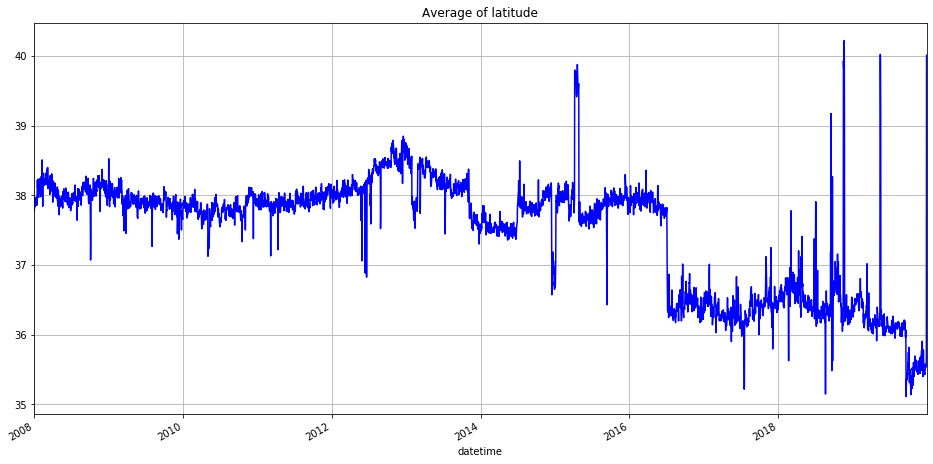

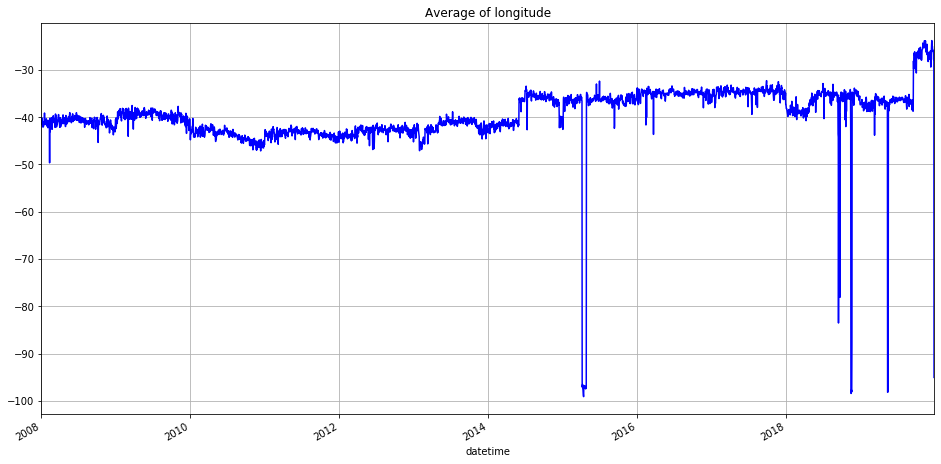

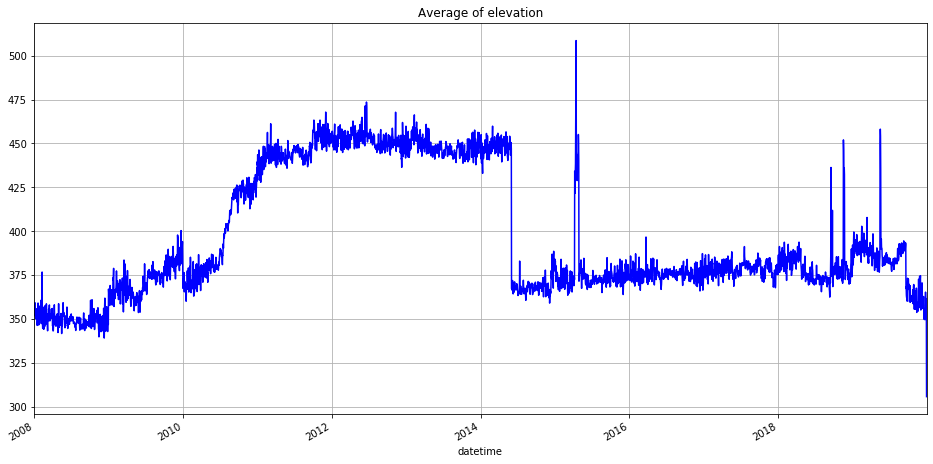

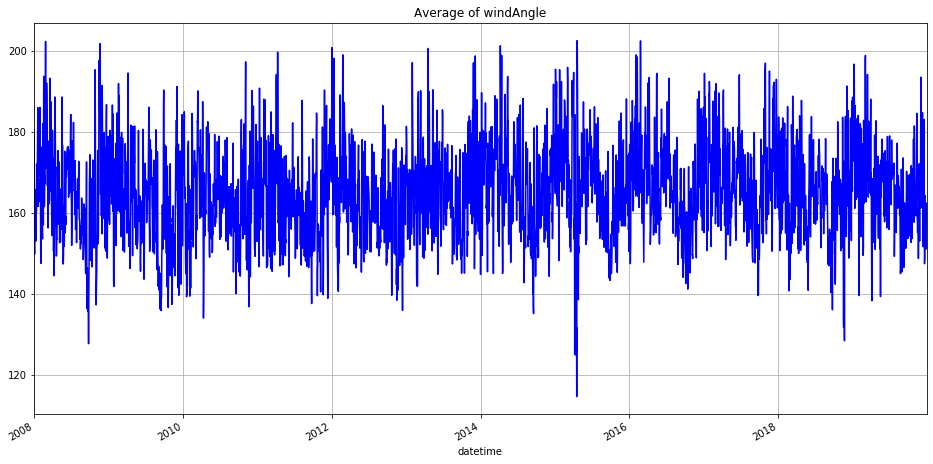

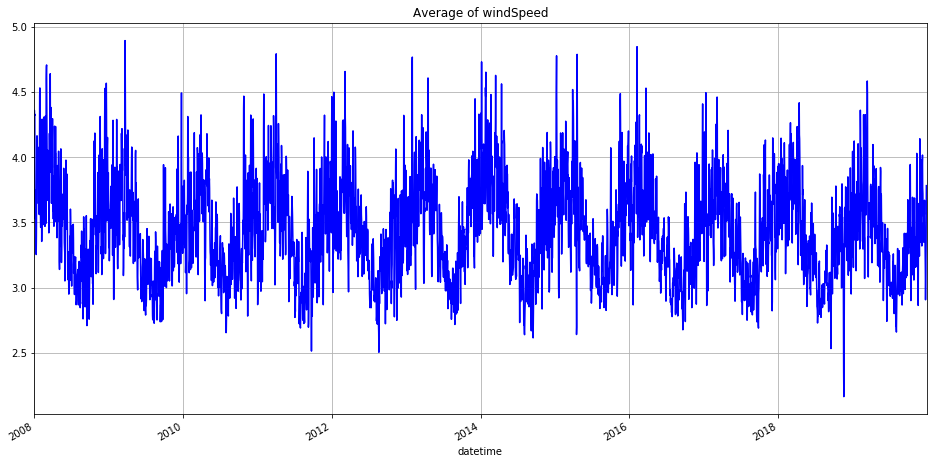

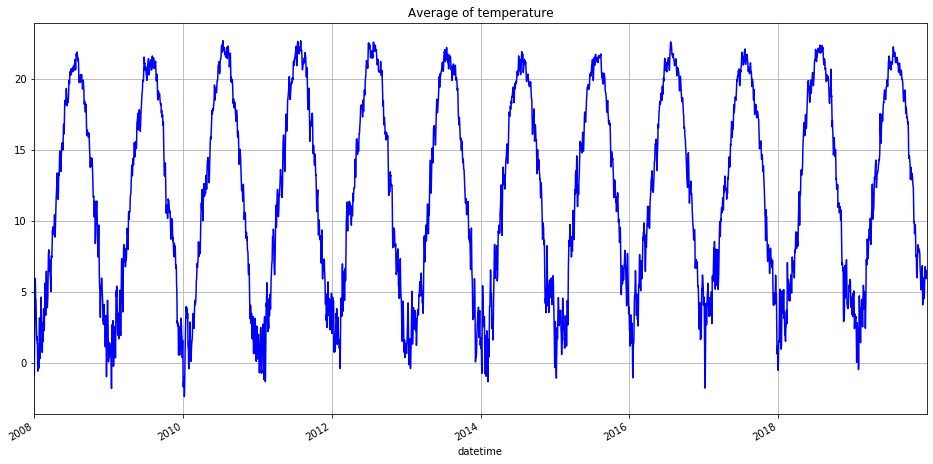

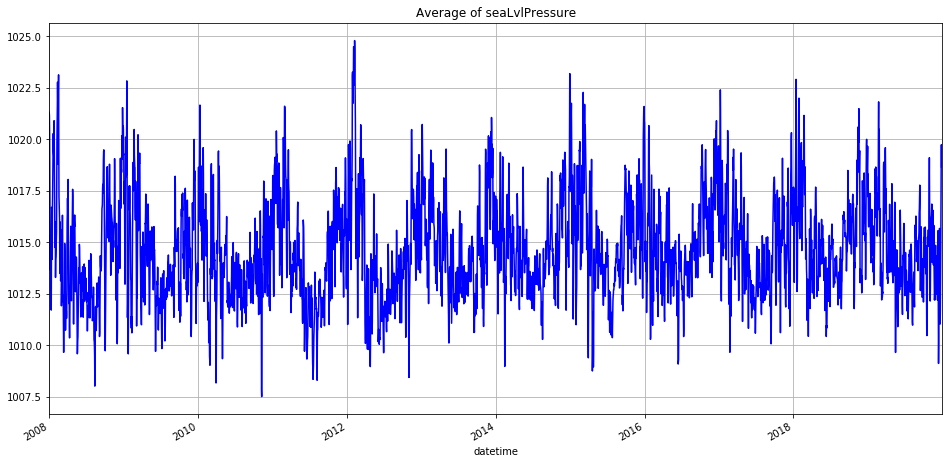

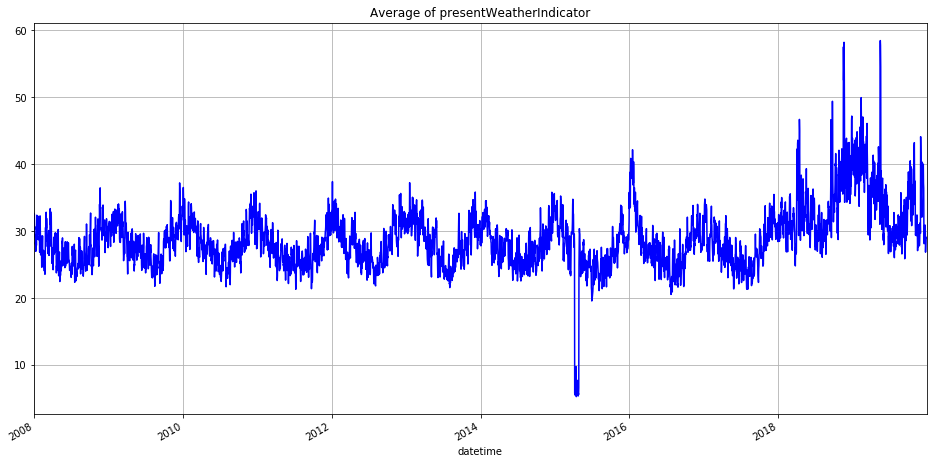

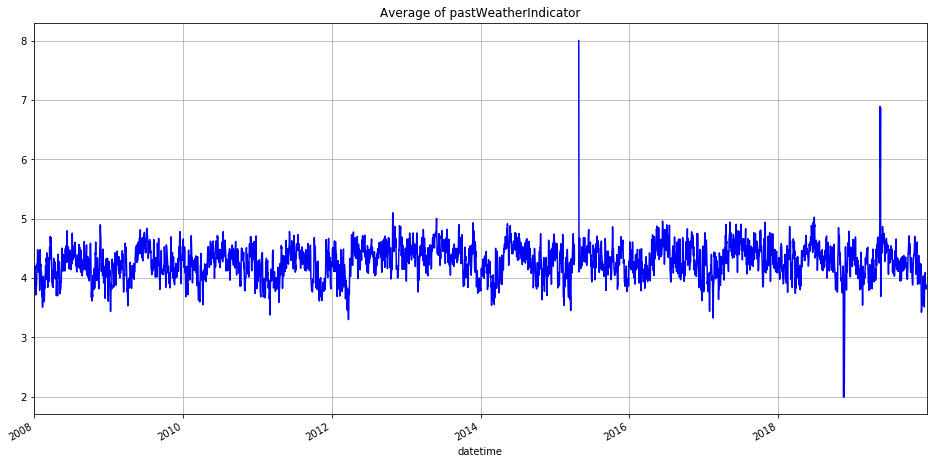

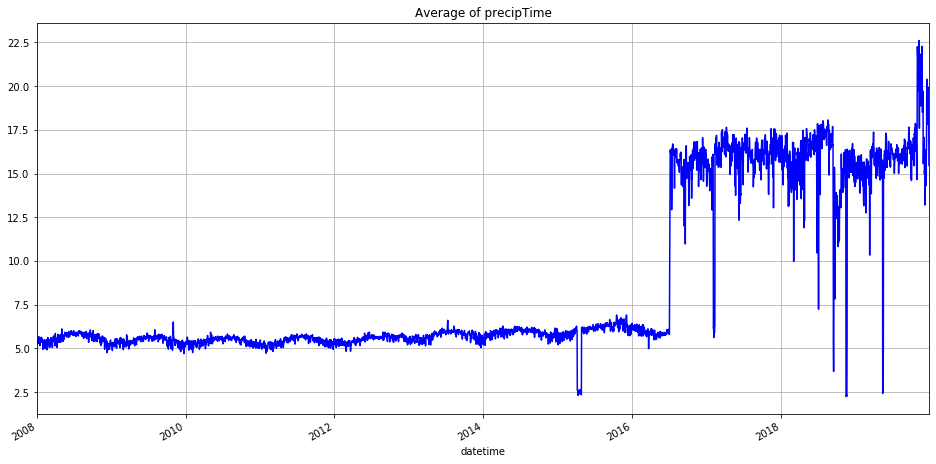

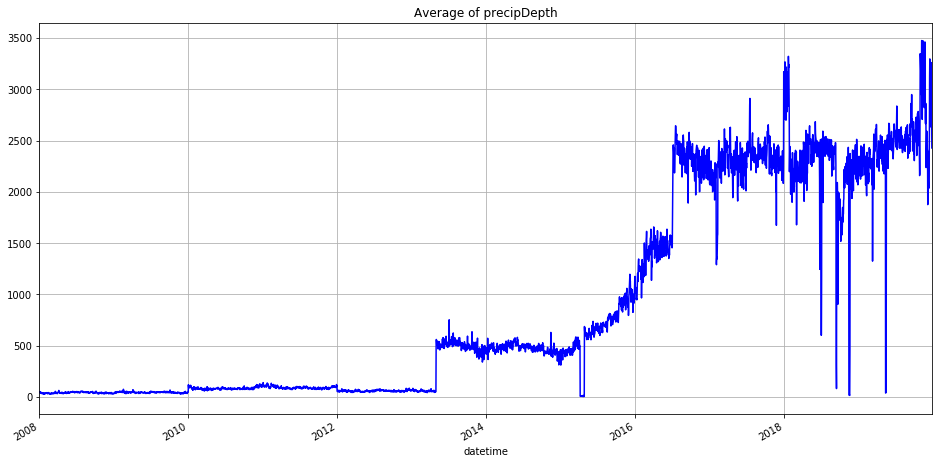

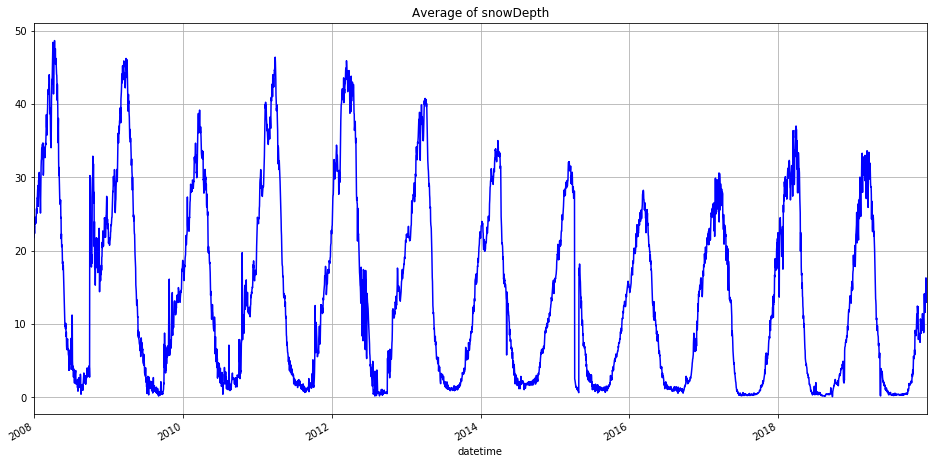

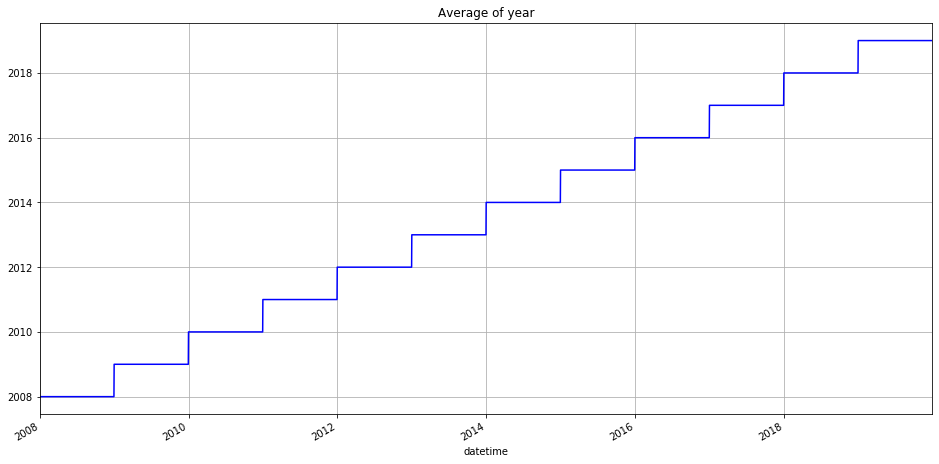

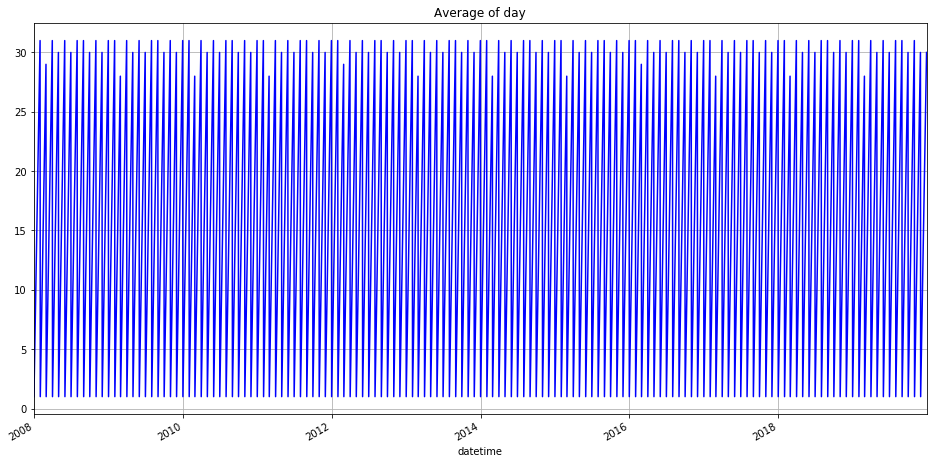

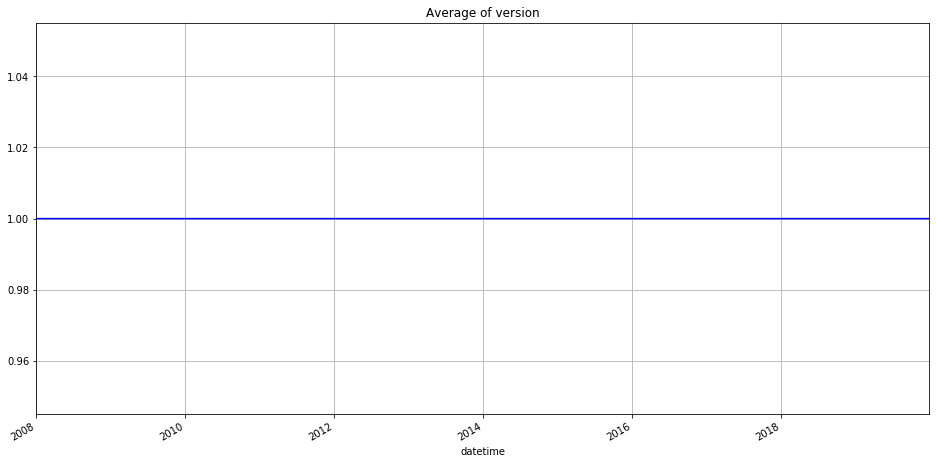

In [40]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2019, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

In [41]:
#df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist() # persist and sort data by day 

## Prepare data

In [42]:
## insert any Pandas-like Dask data prep code 
df['temperature'] = df['temperature']*(9/5)+32       # 'Merica
means['temperature'] = means['temperature']*(9/5)+32 # skip recomputing this 

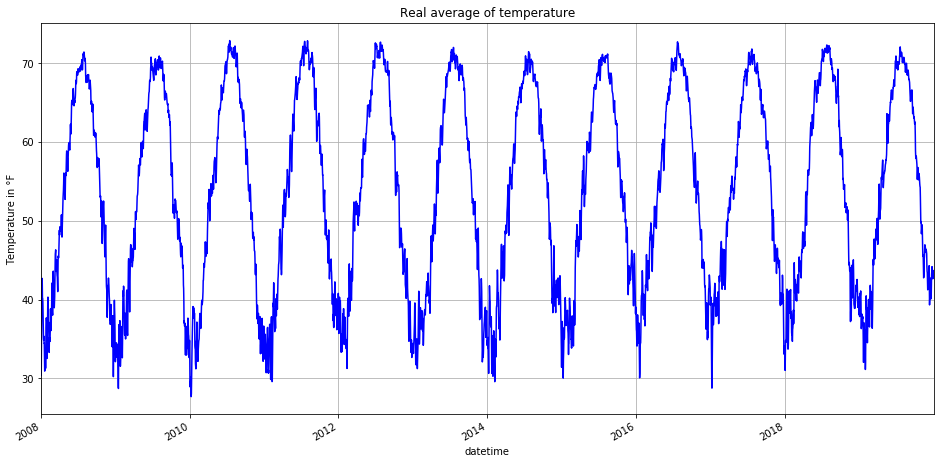

In [43]:
fig = plt.figure(figsize=(16, 8))
means.temperature.plot(color='b')
plt.title('Real average of temperature')
plt.xlim([datetime(2008, 1, 1), datetime(2019, 12, 31)])
plt.ylabel('Temperature in \u00B0F')
plt.grid()

## Write data

**Important:** this is slow and will put 200 GB of CSVs in your default storage.

In [45]:
%time dask.delayed(df.to_csv)(f'/{run.get_metrics()["datastore"]}/dask/output/noaa/data-part-*.csv').compute()

CPU times: user 3.47 s, sys: 436 ms, total: 3.91 s
Wall time: 18min 28s


['//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa000.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa001.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa002.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa003.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa004.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa005.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_1577847486_7dafa33a/mounts/workspaceblobstore/dask/output/noaa006.csv',
 '//mnt/batch/tasks/shared/LS_root/jobs/bigdata2/azureml/dask_

## Create dataset

In [48]:
from azureml.core import Dataset

dset = Dataset.File.from_files((ws.get_default_datastore(), '/dask/output/noaa/**/*.csv'))

In [49]:
dset = dset.register(ws, 'real-weather-files')
dset

{
  "source": [
    "('workspaceblobstore', 'dask/output/noaa*.csv')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "0808a4c6-617e-4ccb-a4cf-e308ead1f840",
    "name": "real-weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata2', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

## End the run

Cluster will return to 0 nodes

In [ ]:
run.cancel()